## Load Libraries

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
from statsmodels.tsa.stattools import adfuller
from mysql.connector import connect, Error
from sqlalchemy import create_engine
import json
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
from prophet import Prophet, serialize
import itertools
from prophet.serialize import model_to_json, model_from_json
from scipy.stats import uniform
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_plotly, plot_components_plotly, plot_cross_validation_metric
import mlflow
import mlflow.prophet
from sklearn.metrics import root_mean_squared_error
import warnings
warnings.filterwarnings("ignore")

## Load Dataset

In [6]:
def load_dataset():
    try:
        nvda = pd.read_csv('../data/raw/nvda_stock_prices_data(2019-10-05 - 2024-10-05).csv')
        gspc = pd.read_csv('../data/raw/gspc_stock_prices_data(2019-10-05 - 2024-10-05).csv')
        return nvda, gspc
    except Exception as e:
        print(e)
df_nvda, df_gspc = load_dataset()


In [7]:
df_nvda.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-10-07,4.61450,4.7085,4.60575,4.60825,4.585944,480984000
1,2019-10-08,4.51600,4.5160,4.41250,4.43075,4.409304,444436000
2,2019-10-09,4.50800,4.5675,4.47900,4.51775,4.495882,292412000
3,2019-10-10,4.51550,4.6270,4.51025,4.57575,4.553600,309124000
4,2019-10-11,4.66025,4.7335,4.64125,4.64975,4.627244,446404000


In [8]:
df_gspc.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-10-07,2944.229980,2959.750000,2935.679932,2938.790039,2938.790039,2959050000
1,2019-10-08,2920.399902,2925.469971,2892.659912,2893.060059,2893.060059,3370700000
2,2019-10-09,2911.100098,2929.320068,2907.409912,2919.399902,2919.399902,2735350000
3,2019-10-10,2918.550049,2948.459961,2917.120117,2938.129883,2938.129883,3234400000
4,2019-10-11,2963.070068,2993.280029,2963.070068,2970.270020,2970.270020,3581320000


In [9]:
df_nvda.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-10-07,4.61450,4.7085,4.60575,4.60825,4.585944,480984000
1,2019-10-08,4.51600,4.5160,4.41250,4.43075,4.409304,444436000
2,2019-10-09,4.50800,4.5675,4.47900,4.51775,4.495882,292412000
3,2019-10-10,4.51550,4.6270,4.51025,4.57575,4.553600,309124000
4,2019-10-11,4.66025,4.7335,4.64125,4.64975,4.627244,446404000


## Exploratory Data Analysis (EDA) with Early Preprocessing

In [10]:
df_nvda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1258 non-null   object 
 1   Open       1258 non-null   float64
 2   High       1258 non-null   float64
 3   Low        1258 non-null   float64
 4   Close      1258 non-null   float64
 5   Adj Close  1258 non-null   float64
 6   Volume     1258 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 68.9+ KB


In [11]:
df_gspc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1258 non-null   object 
 1   Open       1258 non-null   float64
 2   High       1258 non-null   float64
 3   Low        1258 non-null   float64
 4   Close      1258 non-null   float64
 5   Adj Close  1258 non-null   float64
 6   Volume     1258 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 68.9+ KB


In [12]:
def early_preprocess_dataset(df):
    df.columns = df.columns.str.lower()
    df.columns = df.columns.str.replace(' ', '_')
    df['date'] = pd.to_datetime(df['date'])
    return df
df_nvda = early_preprocess_dataset(df_nvda)
df_gspc = early_preprocess_dataset(df_gspc)

## NVIDIA and GSPC Trend Visualization

In [13]:
def stock_plot_history(df,title): 
    fig = go.Figure()
    columns = ['close', 'adj_close']
    for col in columns:
      fig.add_trace(go.Scatter(
        x = df['date'],
        y = df[col],
        mode = 'lines',
        name = col.capitalize() + ' Price')) 
    
    fig.update_layout(
    title = title,
    width=1500, height=400,
    xaxis_title = 'Date',
    yaxis_title = 'Price')
    fig.show()

# def gspc_stock_plot(df): 
#     fig = go.Figure()
#     columns = ['close', 'adj_close']
#     for col in columns:
#       fig.add_trace(go.Scatter(
#         x = df['date'],
#         y = df[col],
#         mode = 'lines',
#         name = col.capitalize() + ' Price')) 
    
#     fig.update_layout(
#     title = ,
#     xaxis_title = 'Date',
#     yaxis_title = 'Price')
#     fig.show()

stock_plot_history(df_nvda,"Close Price and Adjusted Close Price of NVIDIA (NVDA) Stock")
stock_plot_history(df_gspc,"Close Price and Adjusted Close Price of S&P 500 (GSPC) Index")

`Nvidia Stock Data Analysis:`
* Over the last five years, NVIDIA stock prices (Close and Adj Close) have shown a positive trend. After the COVID-19 pandemic (around 2022), the prices began to increase significantly.
* This comparison between Close and Adj Close indicates that there are no significant differences between the two prices, meaning it is acceptable to choose either the Close or Adj Close price.
* At a glance, this data exhibits a pattern (is non-stationary), but to confirm and reject this hypothesis, we will conduct the Augmented Dickey-Fuller Test, as referenced here: (https://www.statology.org/dickey-fuller-test-python/).
    * H0: The time series is non-stationary (has a pattern).
    * H1: The time series is stationary (has no pattern).
* If a p-value > 0.05: H0 fails t
o be rejected
* If a p-value < 0.05: H0 rejected.

`S&P 500 (GSPC) Stock Data Analysis:`
* S&P 500 (GSPC) is a market that tracks large companies listed on US stock exchanges, including NVIDIA (NVDA).
* I will use this index as additional variable, serving as an external factor in the model to improve the prediction NVIDIA's stock prices in the future by capturing broader market trends that reflected in S&P 500.

### Testing for Stationarity Using the Augmented Dickey-Fuller Test

In [14]:
# Generate the ADF test and get p-value
def adf_test(df):
    p_value = adfuller(df['close'])[1]
    if p_value > 0.05:
        print(f'p_value: {p_value}')
        print('H0 failes to be rejected. The time series is not stationary (has a trend or pattern)')
    else:
        print(f'p_value: {p_value}')
        print('H0  rejected. The time series is stationary (has no pattern)')

adf_test(df_nvda)

p_value: 0.9975276111259581
H0 failes to be rejected. The time series is not stationary (has a trend or pattern)


* Augmented Dickey-Fuller (ADF) test show a result that the Close Price at this range time is non stationary
* This result also help us to use certain models that can handle non statsionary data

## Preprocessing

### Provide only date and close price columns for nvidia stock price and GSPC market index

In [15]:
def preprocess_dataset(df):
    df = df[['date', 'close']]
    df = df.rename(columns = {'date': 'ds', 'close': 'y'})
    df['ds'] = pd.to_datetime(df['ds'])
    return df

df_nvda = preprocess_dataset(df_nvda)
df_gspc = preprocess_dataset(df_gspc)

### Merge NVIDIA and GSPC dataframe and split into Train and Test Dataframe

In [16]:
def merge_dataset(df_nvda, df_gspc):
    # date_threshold = '2023-12-31'
    # date_threshold = '2024-03-31'
    date_threshold = '2024-07-31'
    df = pd.merge(df_nvda,df_gspc[['ds','y']],on = 'ds', how = 'left', suffixes = ('','_gspc'))
    df_train = df[df['ds'] <= date_threshold]
    df_test = df[df['ds'] > date_threshold]
    return df_train, df_test

df_train, df_test = merge_dataset(df_nvda,df_gspc)

## Modeling (Facebook Prophet)
Based on the results of the ADF test, we have determined that the dataset for NVIDIA's close price exhibits a non-stationary pattern. Therefore, I will use Facebook Prophet as my primary model to forecast NVIDIA's stock price.


### Base Model

21:30:12 - cmdstanpy - INFO - Chain [1] start processing
21:30:14 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Squared Error (RMSE) Score (Base Model): 13.59


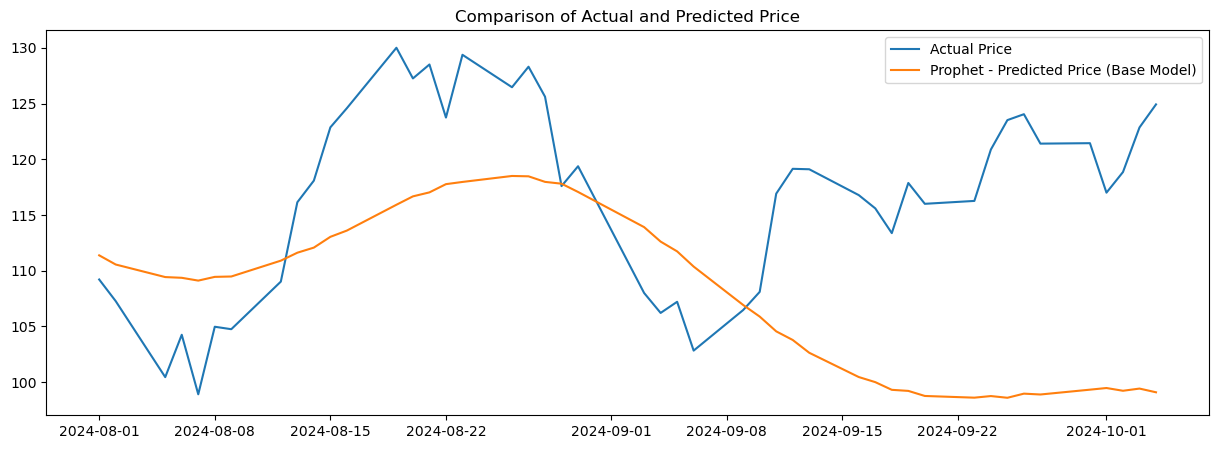

In [17]:
prophet_model = Prophet(seasonality_mode='multiplicative')
future = df_test[['ds']].copy()
prophet_model.fit(df_train)
df_predicted = prophet_model.predict(future)

plt.figure(figsize=(15,5))
plt.plot(df_test['ds'], df_test['y'], label = 'Actual Price')
plt.title('Comparison of Actual and Predicted Price')
plt.plot(df_predicted['ds'],df_predicted['yhat'], label = 'Prophet - Predicted Price (Base Model)')
plt.legend()

rmse = root_mean_squared_error(df_test['y'], df_predicted['yhat'])
print(f'Root Mean Squared Error (RMSE) Score (Base Model): {rmse:.2f}')

### Add Regressor

21:30:14 - cmdstanpy - INFO - Chain [1] start processing
21:30:15 - cmdstanpy - INFO - Chain [1] done processing


RMESE Score (Base): 13.59
RMSE Score (with Regressor): 5.52


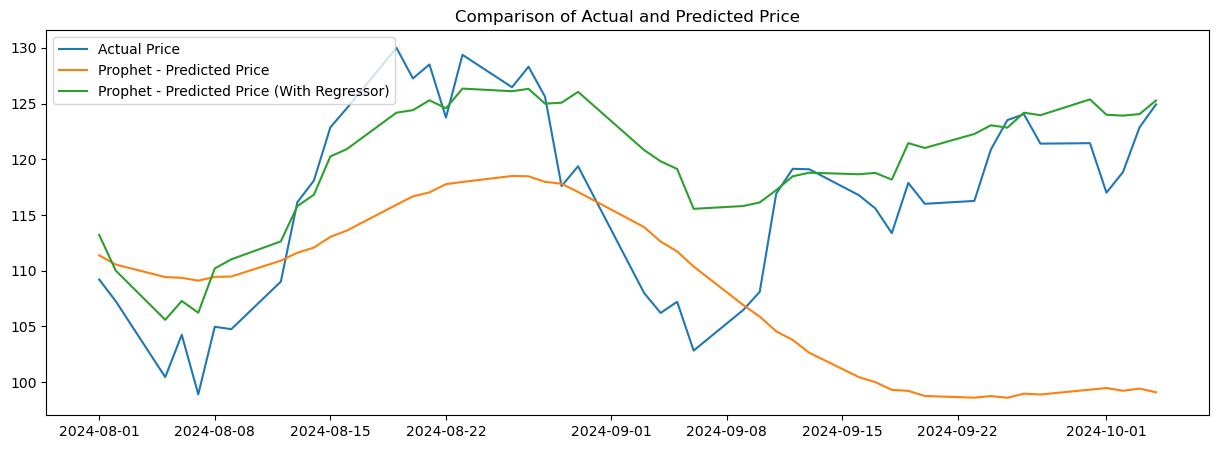

In [18]:
prophet_model_regressor = Prophet(seasonality_mode='multiplicative').add_regressor('y_gspc')
future['y_gspc'] = df_test['y_gspc']
prophet_model_regressor.fit(df_train)
df_predicted_regressor = prophet_model_regressor.predict(future)

plt.figure(figsize=(15,5))
plt.plot(df_test['ds'], df_test['y'], label = 'Actual Price')
plt.plot(df_predicted['ds'],df_predicted['yhat'], label = 'Prophet - Predicted Price')
plt.plot(df_predicted_regressor['ds'],df_predicted_regressor['yhat'], label = 'Prophet - Predicted Price (With Regressor)')
plt.title('Comparison of Actual and Predicted Price')
plt.plot(type = 'scatter')
plt.legend()

rmse_regressor = root_mean_squared_error(df_test['y'], df_predicted_regressor['yhat'])

print(f'RMESE Score (Base): {rmse:.2f}')
print(f'RMSE Score (with Regressor): {rmse_regressor:.2f}')

In [19]:
asd

NameError: name 'asd' is not defined

### Hyperparameter Tuning ARIMA with Time Series Cross Validation 

In [29]:
def train_model(df_train,df_test):
    param_grid = {
        'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
        'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
        'seasonality_mode' : ["multiplicative"],
        'holidays_prior_scale': [0.01, 10],
        'interval_width': [0.8, 0.95],
        'daily_seasonality' : [True, False]}
    all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
    best_rmse = float('inf')
    best_params = None

    # Use cross validation to evaluate all parameters
    for params in all_params:
        model_opt = Prophet(**params).fit(df_train[['ds','y']])
        future = df_test[['ds']].copy()
        df_predicted_opt = model_opt.predict(future)[['ds','yhat']]
        rmse = root_mean_squared_error(df_test['y'], df_predicted['yhat'])
    if rmse < best_rmse:
        best_rmse = rmse
        best_params = params
    return best_rmse, best_params

In [31]:
best_rmse, best_params = train_model(df_train, df_test)

21:41:17 - cmdstanpy - INFO - Chain [1] start processing
21:41:17 - cmdstanpy - INFO - Chain [1] done processing
21:41:17 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:41:17 - cmdstanpy - INFO - Chain [1] start processing
21:41:22 - cmdstanpy - INFO - Chain [1] done processing
21:41:22 - cmdstanpy - INFO - Chain [1] start processing
21:41:22 - cmdstanpy - INFO - Chain [1] done processing
21:41:22 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:41:22 - cmdstanpy - INFO - Chain [1] start processing
21:41:26 - cmdstanpy - INFO - Chain [1] done processing
21:41:26 - cmdstanpy - INFO - Chain [1] start processing
21:41:26 - cmdstanpy - INFO - Chain [1] done processing
21:41:26 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abn

In [32]:
best_rmse,best_params

(13.594925980363785,
 {'changepoint_prior_scale': 0.5,
  'seasonality_prior_scale': 10.0,
  'seasonality_mode': 'multiplicative',
  'holidays_prior_scale': 10,
  'interval_width': 0.95,
  'daily_seasonality': False})

#### Save Best Prophet Best Parameters

In [ ]:
# with open('../config/prophet_best_params.json', 'w') as f:
#     f.write(json.dumps(best_params))

### Prophet with Best Params

In [ ]:
# #Load Params from JSON
# with open('../config/prophet_best_params.json', 'r') as f:
#     f = json.loads(f.read())
#     best_params = f

21:52:07 - cmdstanpy - INFO - Chain [1] start processing
21:52:08 - cmdstanpy - INFO - Chain [1] done processing


RMESE Score (Base): 13.59
RMSE Score (Opt with Regressor): 5.52
RMSE Score(Hyper Parameter Tuning): 14.32


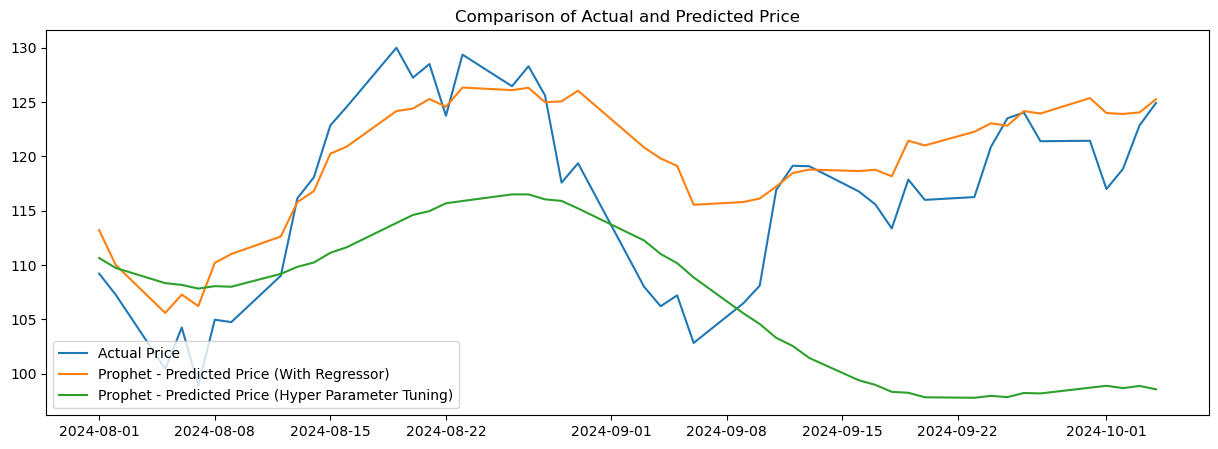

: 

In [35]:
#Predict with best params 
prophet_model_opt = Prophet(**best_params).fit(df_train)
df_predicted_opt = prophet_model_opt.predict(future)
plt.figure(figsize=(15,5))
plt.plot(df_test['ds'], df_test['y'], label = 'Actual Price')
plt.plot(df_predicted_regressor['ds'],df_predicted_regressor['yhat'], label = 'Prophet - Predicted Price (With Regressor)')
plt.plot(df_predicted_opt['ds'],df_predicted_opt['yhat'], label = 'Prophet - Predicted Price (Hyper Parameter Tuning)')
plt.title('Comparison of Actual and Predicted Price')
plt.legend()

rmse_opt = root_mean_squared_error(df_test['y'], df_predicted_opt['yhat'])
print(f'RMESE Score (Base): {rmse:.2f}')
print(f'RMSE Score (Opt with Regressor): {rmse_regressor:.2f}')
print(f'RMSE Score(Hyper Parameter Tuning): {rmse_opt:.2f}')




## Model Inference

In this step i will try to predict the the NVIDIA stock price from 2024-10-13 to 2024-10-06
1. Retrive nvidia and gspc stock data from yahoo finance
2. Preprocess until normalization and extract the date as a future variable (which will we use as a predicted variable)
3. Compare the predict result with the actual stock nvidia price in range2024-10-13 to 2024-10-06

### Extract Stock Price from Yahoo Finance

In [ ]:
def get_stock_data(ticker_code, start_date, end_date):
    return yf.download(ticker_code, start=start_date, end=end_date).reset_index()

def preprocess_data(ticker_code, start_date, end_date):
    df = get_stock_data(ticker_code, start_date, end_date)
    df = early_preprocess_dataset(df)
    df = preprocess_dataset(df)
    return df

# Tentukan tanggal dan kode saham
start_date = '2024-10-06'
end_date = '2024-10-14'

# Proses data untuk NVDA dan GSPC
df_nvda_inference = preprocess_data('NVDA', start_date, end_date)
df_gspc_inference = preprocess_data('^GSPC', start_date, end_date)

# Gabungkan DataFrame
df_inference = pd.merge(df_nvda_inference, df_gspc_inference, on='ds', how='left', suffixes=('', '_gspc'))

# Buat variable future untuk store ds and gspc
future_inference = df_inference[['ds','y_gspc']].copy()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


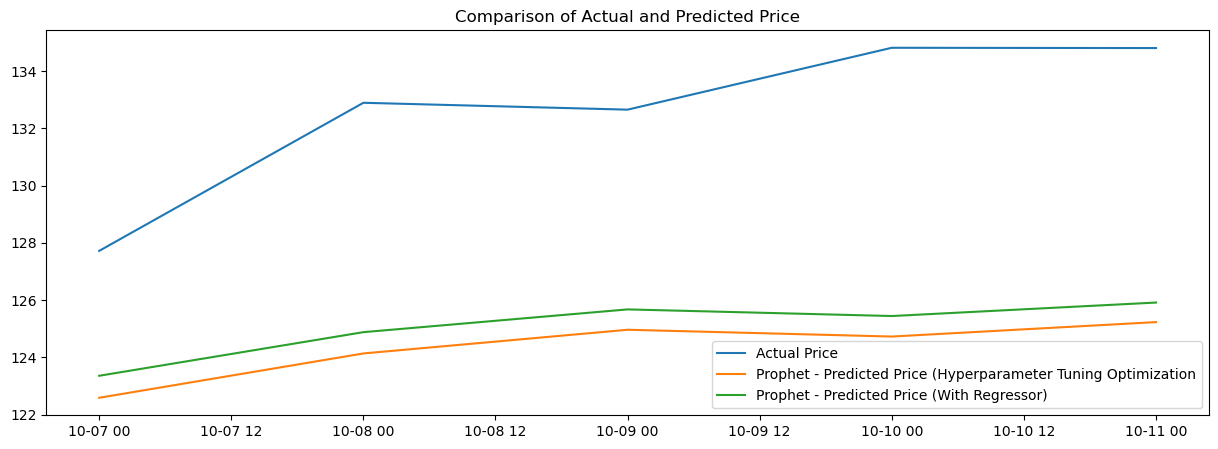

RMSE Score: 8.43
RMSE Score: 7.73


In [ ]:
df_predicted_inference = prophet_model_opt.predict(future_inference)
df_predicted_inference_v2 = prophet_model_regressor.predict(future_inference)
plt.figure(figsize=(15,5))
plt.plot(df_inference['ds'], df_inference['y'], label = 'Actual Price')
plt.plot(df_predicted_inference['ds'],df_predicted_inference['yhat'], label = 'Prophet - Predicted Price (Hyperparameter Tuning Optimization')
plt.plot(df_predicted_inference_v2['ds'],df_predicted_inference_v2['yhat'], label = 'Prophet - Predicted Price (With Regressor)')
plt.title('Comparison of Actual and Predicted Price')
plt.legend()
plt.show()

rmse_inference = root_mean_squared_error(df_inference['y'], df_predicted_inference['yhat'])
rmse_inference_v2 = root_mean_squared_error(df_inference['y'], df_predicted_inference_v2['yhat'])
print(f'RMSE Score: {rmse_inference:.2f}')
print(f'RMSE Score: {rmse_inference_v2:.2f}')


In [ ]:
import holidays
import pandas as pd
import os
from prophet.serialize import model_from_json
import yfinance as yf
from datetime import datetime, timedelta

In [ ]:
def load_model():
    json_path = os.path.join(os.getcwd(),'..','config')
    file_name = 'json_prophet_model.json'
    file_path = os.path.join(json_path, file_name)
    print(file_path)
    try:
        if os.path.exists(file_path):
            with open (file_path, 'r') as f: 
                model = model_from_json(f.read())
            return model
        else:
            print('file does not exist')
    except Exception as e:
        print(e)

def get_date():
    date_min = datetime(2024, 10, 6) 
    date_threshold = datetime (2024, 10, 5)
    date_max = date_min + timedelta(days=7)
    us_holidays = holidays.US()

    if date_min <= date_threshold:
        print('Date not allowed, please raise the date over 5th of October, 2024')
    else:
        future_date = pd.DataFrame({'ds':pd.date_range(date_min, date_max)})
        future_date = future_date[~(future_date.ds.isin(us_holidays) | future_date.ds.dt.dayofweek.isin([5,6]))] #exclude holidays date (include Saturday and Sunday)
        return future_date

def predict_future(model, future_date):
    df_predicted = model.predict(future_date)
    return df_predicted




In [ ]:
model = load_model()
future_date= get_date()


c:\Users\Fadhil\Documents\Data Science\projects\Time-Series-Forecasting-of-NVIDIA-Stock-Prices-Using-Prophet\notebooks\..\config\json_prophet_model.json


In [ ]:
df_predicted = predict_future(model, future_date)

ValueError: Regressor 'y_gspc' missing from dataframe

[*********************100%***********************]  1 of 1 completed

c:\Users\Fadhil\Documents\Data Science\projects\Time-Series-Forecasting-of-NVIDIA-Stock-Prices-Using-Prophet\notebooks\..\config\json_prophet_model.json



C:\Users\Fadhil\AppData\Local\Temp\ipykernel_32524\2079763779.py:35: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


          ds        yhat
0 2024-10-07  122.211155
1 2024-10-08  123.789526
2 2024-10-09  124.645740
3 2024-10-10  124.394674
4 2024-10-11  124.909976


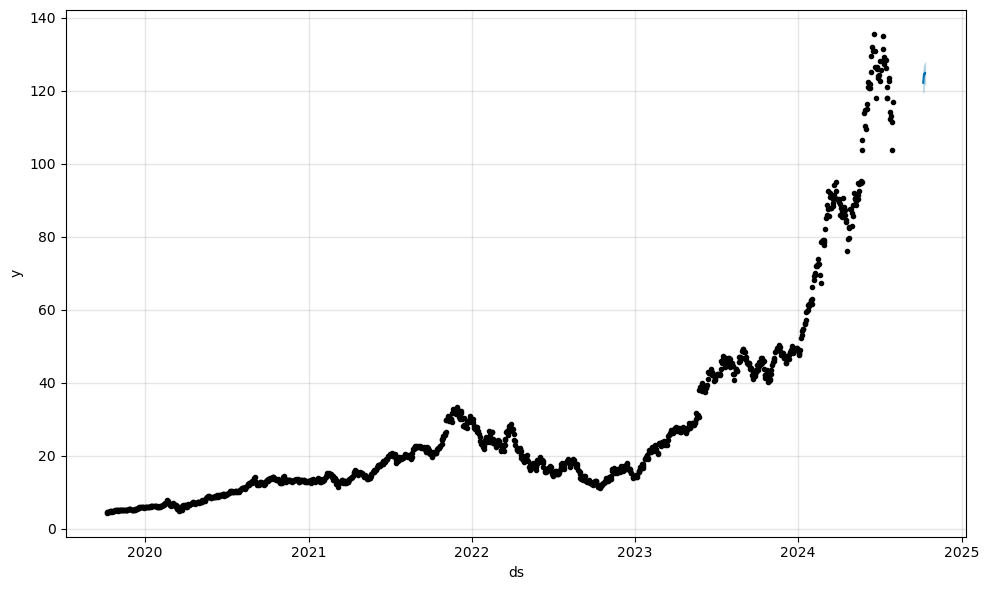

In [ ]:
model = load_model()
print(model)
future_date = get_date()
# df_predicted = model.predict(future_date)
df_predicted = predict_future(model, future_date)
print(df_predicted[['ds','yhat']])
plot_future(model,df_predicted[df_predicted['ds'] >= '2024-10-07'])

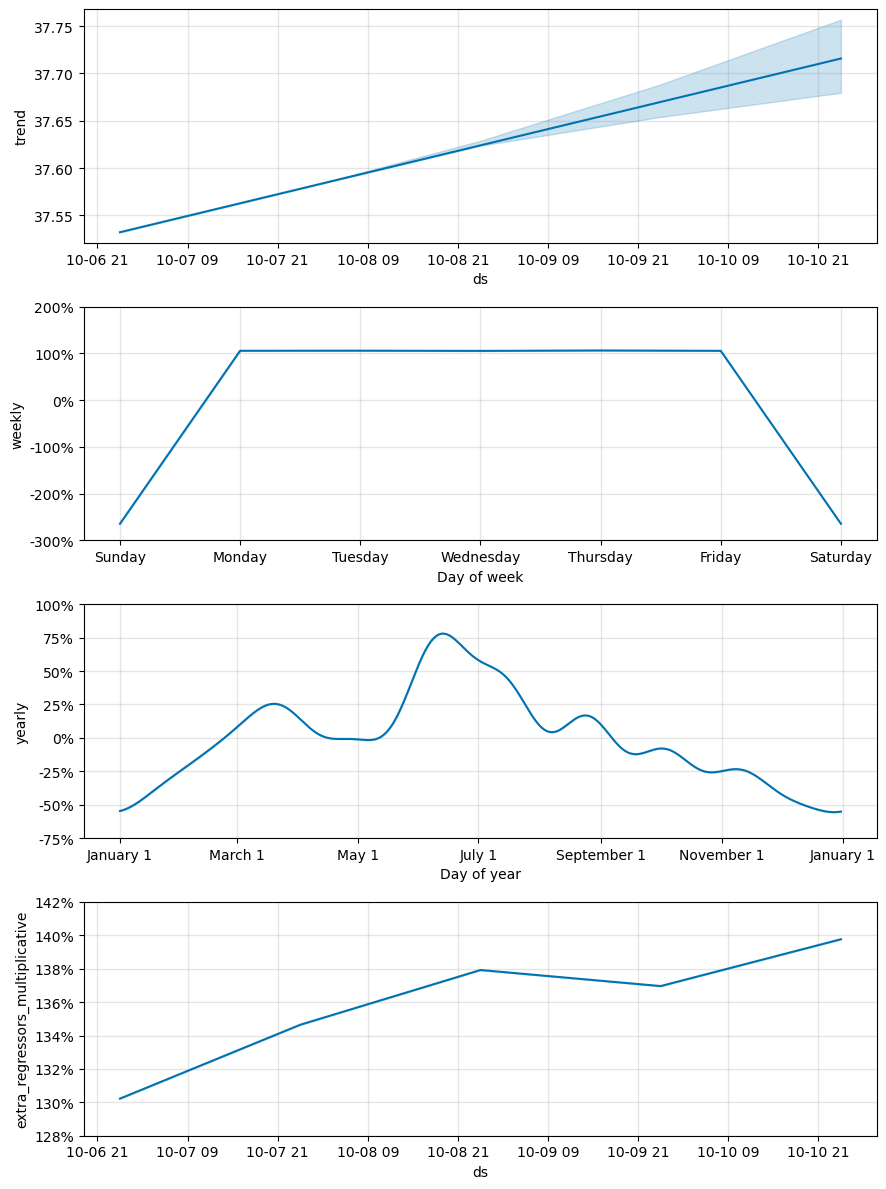

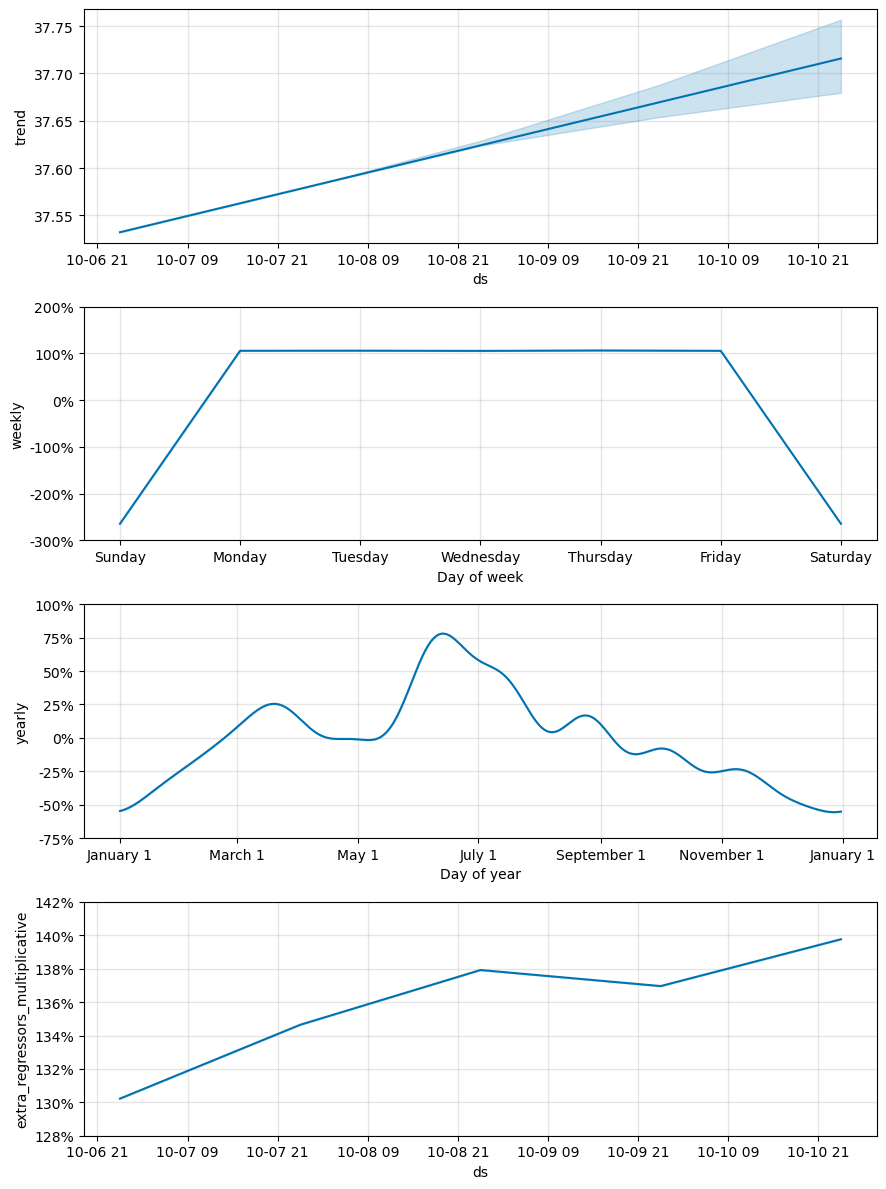

In [ ]:
model.plot_components(df_predicted)

In [ ]:
from datetime import datetime, timedelta
date_min = '2024-10-06'
date_min = datetime.strptime(date_min, '%Y-%m-%d')
date_threshold = datetime(2024,10,5)
date_max = date_min + timedelta(days=7)

In [ ]:
date_max

datetime.datetime(2024, 10, 13, 0, 0)